In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

c:\Users\rkn\.virtualenvs\lab-work-bsKSxQpa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rkn\.virtualenvs\lab-work-bsKSxQpa\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = 'Affectnet/Manually_Annotated/Manually_Annotated_Images'

In [4]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
import os


def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class AffectNetDataset(Dataset):
    def __init__(self,
                 csvfile,
                 root,
                 mode='classification',
                 crop=False,
                 transform=None,
                 invalid_files=None):
        self.df = pd.read_csv(csvfile)
        self.root = root
        self.mode = mode
        self.crop = crop
        self.transform = transform
        self.invalid_files = invalid_files
        
        if self.invalid_files:
            self.df = self.df[~self.df['subDirectory_filePath'].isin(invalid_files)]
            self.df = self.df
        
        self.df = self.df[~((self.df['expression'] == 9) | (self.df['expression'] == 10))].reset_index(drop=True)
    
    def __getitem__(self, idx):
        try:
            img = pil_loader(os.path.join(self.root, self.df['subDirectory_filePath'][idx]))
        except KeyError:
            raise IndexError
        if self.crop:
            img = img.crop((self.df['face_x'][idx],
                            self.df['face_y'][idx],
                            self.df['face_x'][idx]+self.df['face_width'][idx],
                            self.df['face_y'][idx]+self.df['face_height'][idx],))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'classification':
            target = torch.tensor(self.df['expression'][idx])
        elif self.mode == 'valence':
            target = torch.tensor([self.df['valence'][idx]])
        elif self.mode == 'arousal':
            target = torch.tensor([self.df['arousal'][idx]])
        else:
            target = torch.tensor([self.df['valence'][idx],
                                   self.df['arousal'][idx]])
        return img.float(), target.float()
    
    def __len__(self):
        return len(self.df)

In [5]:
from tqdm import tqdm

import pandas as pd

train_df = pd.read_csv('Affectnet/training.csv')
val_df = pd.read_csv('Affectnet/validation.csv')

def check_files(df):
    invalid_files = []
    for filename in tqdm(df['subDirectory_filePath']):
        try:
            pil_loader(os.path.join(images_root, filename))
        except:
            invalid_files.append(filename)
    print(invalid_files)
    return invalid_files

# train_invalid_files = check_files(train_df)
# val_invalid_files = check_files(val_df)

In [6]:
train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']
val_invalid_files = []

In [7]:
mode = 'arousal'
seed = 0

In [8]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor)
from torch.utils.data import random_split


normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([Resize(tuple(feature_extractor.size.values())),
                     ToTensor()])

train_dataset = AffectNetDataset('Affectnet/training.csv',
                                 images_root,
                                 mode,
                                 crop=False,
                                 transform=transform,
                                 invalid_files=train_invalid_files)

val_dataset = AffectNetDataset('Affectnet/validation.csv',
                               images_root,
                               mode,
                               crop=False,
                               transform=transform,
                               invalid_files=val_invalid_files)

print('train:', len(train_dataset))
print('validation:', len(val_dataset))


train: 320739
validation: 4500


In [9]:
def collate_fn(examples):
    imgs, targets = zip(*examples)
    pixel_values = torch.stack(imgs)
    targets = torch.stack(targets)
    return {'pixel_values': pixel_values, 'labels': targets}

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4, 1])


In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=1,
                                                  problem_type='regression')


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Balanced MSE
- paper: https://openaccess.thecvf.com/content/CVPR2022/papers/Ren_Balanced_MSE_for_Imbalanced_Visual_Regression_CVPR_2022_paper.pdf
- github: https://github.com/jiawei-ren/BalancedMSE/tree/main

Batch-based Monte-Carlo (BMC)を使う

In [14]:
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from torch.distributions import MultivariateNormal as MVN

def bmc_loss_md(pred, target, noise_var, device):
    I = torch.eye(pred.shape[-1]).to(device)
    logits = MVN(pred.unsqueeze(1), noise_var*I).log_prob(target.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.arange(pred.shape[0]).to(device))
    loss = loss * (2 * noise_var).detach()
    
    return loss

class BMCLoss(_Loss):
    def __init__(self, init_noise_sigma=1., device=None, root=False):
        super(BMCLoss, self).__init__()
        self.noise_sigma = torch.nn.Parameter(torch.tensor(init_noise_sigma))
        self.device = device
        self.root = root
    
    def forward(self, pred, target):
        noise_var = self.noise_sigma ** 2
        loss = bmc_loss_md(pred, target, noise_var, self.device)
        return torch.sqrt(loss) if self.root else loss

In [15]:
from transformers import Trainer

class BMCLossTrainer(Trainer):
    def __init__(self,
                 model = None,
                 args = None,
                 data_collator = None,
                 train_dataset = None,
                 eval_dataset = None,
                 tokenizer = None,
                 model_init = None,
                 compute_metrics = None,
                 callbacks = None,
                 optimizers = (None, None),
                 preprocess_logits_for_metrics = None):
        super().__init__(model, args, data_collator, train_dataset, eval_dataset, tokenizer, model_init, compute_metrics, callbacks, optimizers, preprocess_logits_for_metrics)
        self.loss_fct = BMCLoss(device=self.args.device).to(self.args.device)
    
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss = self.loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [16]:
from transformers import TrainingArguments
import wandb

wandb.init(project='AffectNet-vit', name='arousal')

args = TrainingArguments(
    f"affectnet-balancedMSE-aro-no910",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    weight_decay=1e-3,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [17]:
from sklearn.metrics import mean_squared_error

def compute_metrics(eval_pred):
    preds, targets = eval_pred
    rmse = mean_squared_error(targets, preds, squared=False) / 2
    return {'rmse': rmse}

# class ComputeMetrics(object):
#     def __init__(self):
#         self.metrics = BMCLoss(device=device).to(device)
    
#     def __call__(self, eval_pred):
#         preds, targets = eval_pred
#         preds, targets = torch.tensor(preds).to(device), torch.tensor(targets).to(device)
#         bmse = self.metrics(preds, targets)
#         rmse = compute_metrics(eval_pred)
#         return {'bmse': bmse, 'rmse': rmse}

# compute_bmse_metrics = ComputeMetrics()


In [18]:
from transformers import EarlyStoppingCallback

trainer = BMCLossTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    # compute_metrics=compute_bmse_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [19]:
trainer.train()

c:\Users\rkn\.virtualenvs\lab-work-bsKSxQpa\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 320739
  Num Epochs = 30
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 300720
  Number of trainable parameters = 85799425
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
  0%|          | 500/300720 [07:30<86:52:23,  1.04s/it] 

{'loss': 6.9282, 'learning_rate': 9.98337323756318e-07, 'epoch': 0.05}


  0%|          | 1000/300720 [14:14<79:09:11,  1.05it/s]

{'loss': 6.9016, 'learning_rate': 9.966746475126364e-07, 'epoch': 0.1}


  0%|          | 1500/300720 [22:01<81:21:40,  1.02it/s]

{'loss': 6.8669, 'learning_rate': 9.950119712689545e-07, 'epoch': 0.15}


  1%|          | 2000/300720 [29:16<64:39:31,  1.28it/s]

{'loss': 6.8348, 'learning_rate': 9.933492950252726e-07, 'epoch': 0.2}


  1%|          | 2500/300720 [36:12<66:22:19,  1.25it/s]

{'loss': 6.8175, 'learning_rate': 9.916866187815907e-07, 'epoch': 0.25}


  1%|          | 3000/300720 [43:01<65:21:22,  1.27it/s]

{'loss': 6.8063, 'learning_rate': 9.90023942537909e-07, 'epoch': 0.3}


  1%|          | 3500/300720 [49:42<67:06:10,  1.23it/s]

{'loss': 6.8032, 'learning_rate': 9.88361266294227e-07, 'epoch': 0.35}


  1%|▏         | 4000/300720 [56:51<78:57:28,  1.04it/s]

{'loss': 6.7841, 'learning_rate': 9.866985900505454e-07, 'epoch': 0.4}


  1%|▏         | 4500/300720 [1:04:48<73:43:59,  1.12it/s]

{'loss': 6.7815, 'learning_rate': 9.850359138068635e-07, 'epoch': 0.45}


  2%|▏         | 5000/300720 [1:12:32<75:04:24,  1.09it/s]

{'loss': 6.7647, 'learning_rate': 9.833732375631816e-07, 'epoch': 0.5}


  2%|▏         | 5500/300720 [1:20:39<76:20:37,  1.07it/s]

{'loss': 6.7612, 'learning_rate': 9.817105613194997e-07, 'epoch': 0.55}


  2%|▏         | 6000/300720 [1:27:40<61:23:26,  1.33it/s]

{'loss': 6.7529, 'learning_rate': 9.80047885075818e-07, 'epoch': 0.6}


  2%|▏         | 6500/300720 [1:34:05<62:07:32,  1.32it/s]

{'loss': 6.7552, 'learning_rate': 9.783852088321361e-07, 'epoch': 0.65}


  2%|▏         | 7000/300720 [1:40:29<63:26:53,  1.29it/s]

{'loss': 6.7417, 'learning_rate': 9.767225325884544e-07, 'epoch': 0.7}


  2%|▏         | 7500/300720 [1:48:13<79:07:16,  1.03it/s]

{'loss': 6.7383, 'learning_rate': 9.750598563447725e-07, 'epoch': 0.75}


  3%|▎         | 8000/300720 [1:54:44<62:04:22,  1.31it/s]

{'loss': 6.7318, 'learning_rate': 9.733971801010906e-07, 'epoch': 0.8}


  3%|▎         | 8500/300720 [2:01:49<75:42:00,  1.07it/s]

{'loss': 6.7331, 'learning_rate': 9.71734503857409e-07, 'epoch': 0.85}


  3%|▎         | 9000/300720 [2:09:39<75:01:54,  1.08it/s]

{'loss': 6.7268, 'learning_rate': 9.70071827613727e-07, 'epoch': 0.9}


  3%|▎         | 9500/300720 [2:17:29<77:12:39,  1.05it/s]

{'loss': 6.7159, 'learning_rate': 9.684091513700452e-07, 'epoch': 0.95}


  3%|▎         | 10000/300720 [2:25:16<77:48:53,  1.04it/s]

{'loss': 6.7086, 'learning_rate': 9.667464751263633e-07, 'epoch': 1.0}


  3%|▎         | 10024/300720 [2:25:38<62:29:28,  1.29it/s]***** Running Evaluation *****
  Num examples = 4500
  Batch size = 16
                                                           
  3%|▎         | 10024/300720 [2:26:56<62:29:28,  1.29it/s]Saving model checkpoint to affectnet-balancedMSE-aro-no910\checkpoint-10024
Configuration saved in affectnet-balancedMSE-aro-no910\checkpoint-10024\config.json


{'eval_loss': 5.3317646980285645, 'eval_rmse': 0.7030057907104492, 'eval_runtime': 78.1719, 'eval_samples_per_second': 57.565, 'eval_steps_per_second': 3.607, 'epoch': 1.0}


Model weights saved in affectnet-balancedMSE-aro-no910\checkpoint-10024\pytorch_model.bin
Image processor saved in affectnet-balancedMSE-aro-no910\checkpoint-10024\preprocessor_config.json
  3%|▎         | 10500/300720 [2:34:27<75:20:28,  1.07it/s]  

{'loss': 6.7037, 'learning_rate': 9.650837988826816e-07, 'epoch': 1.05}


  4%|▎         | 11000/300720 [2:42:16<75:34:25,  1.06it/s]

{'loss': 6.6995, 'learning_rate': 9.634211226389997e-07, 'epoch': 1.1}


  4%|▍         | 11500/300720 [2:50:03<70:44:16,  1.14it/s]

{'loss': 6.688, 'learning_rate': 9.61758446395318e-07, 'epoch': 1.15}


  4%|▍         | 12000/300720 [2:57:50<73:57:53,  1.08it/s]

{'loss': 6.6853, 'learning_rate': 9.60095770151636e-07, 'epoch': 1.2}


  4%|▍         | 12500/300720 [3:05:38<73:05:14,  1.10it/s]

{'loss': 6.6834, 'learning_rate': 9.584330939079542e-07, 'epoch': 1.25}


  4%|▍         | 13000/300720 [7:16:43<75:18:11,  1.06it/s]      

{'loss': 6.6901, 'learning_rate': 9.567704176642723e-07, 'epoch': 1.3}


  4%|▍         | 13500/300720 [7:24:40<72:53:13,  1.09it/s]

{'loss': 6.6846, 'learning_rate': 9.551077414205906e-07, 'epoch': 1.35}


  5%|▍         | 14000/300720 [7:32:38<77:13:07,  1.03it/s]

{'loss': 6.6818, 'learning_rate': 9.534450651769087e-07, 'epoch': 1.4}


  5%|▍         | 14500/300720 [7:40:32<77:17:58,  1.03it/s]

{'loss': 6.6676, 'learning_rate': 9.517823889332269e-07, 'epoch': 1.45}


  5%|▍         | 15000/300720 [7:48:25<79:21:32,  1.00it/s]

{'loss': 6.6667, 'learning_rate': 9.50119712689545e-07, 'epoch': 1.5}


  5%|▌         | 15500/300720 [7:56:15<74:06:28,  1.07it/s]

{'loss': 6.6692, 'learning_rate': 9.484570364458632e-07, 'epoch': 1.55}


  5%|▌         | 16000/300720 [8:04:07<76:48:39,  1.03it/s]

{'loss': 6.6796, 'learning_rate': 9.467943602021814e-07, 'epoch': 1.6}


  5%|▌         | 16500/300720 [8:11:58<73:41:52,  1.07it/s]

{'loss': 6.6644, 'learning_rate': 9.451316839584995e-07, 'epoch': 1.65}


  6%|▌         | 17000/300720 [10:15:59<74:37:26,  1.06it/s]      

{'loss': 6.6567, 'learning_rate': 9.434690077148177e-07, 'epoch': 1.7}


  6%|▌         | 17500/300720 [10:23:47<72:43:22,  1.08it/s]

{'loss': 6.6682, 'learning_rate': 9.418063314711358e-07, 'epoch': 1.75}


  6%|▌         | 18000/300720 [10:31:21<75:27:55,  1.04it/s]

{'loss': 6.6655, 'learning_rate': 9.40143655227454e-07, 'epoch': 1.8}


  6%|▌         | 18500/300720 [10:39:13<70:26:12,  1.11it/s]

{'loss': 6.6678, 'learning_rate': 9.384809789837723e-07, 'epoch': 1.85}


  6%|▋         | 19000/300720 [10:47:03<72:22:27,  1.08it/s]

{'loss': 6.6598, 'learning_rate': 9.368183027400905e-07, 'epoch': 1.9}


  6%|▋         | 19500/300720 [10:55:16<62:13:33,  1.26it/s]

{'loss': 6.6596, 'learning_rate': 9.351556264964086e-07, 'epoch': 1.95}


  7%|▋         | 20000/300720 [11:03:21<76:31:02,  1.02it/s]

{'loss': 6.6502, 'learning_rate': 9.334929502527268e-07, 'epoch': 2.0}


  7%|▋         | 20048/300720 [11:04:07<56:46:56,  1.37it/s]***** Running Evaluation *****
  Num examples = 4500
  Batch size = 16
                                                            
  7%|▋         | 20048/300720 [11:05:31<56:46:56,  1.37it/s]Saving model checkpoint to affectnet-balancedMSE-aro-no910\checkpoint-20048
Configuration saved in affectnet-balancedMSE-aro-no910\checkpoint-20048\config.json


{'eval_loss': 5.296969413757324, 'eval_rmse': 0.8275389671325684, 'eval_runtime': 83.3488, 'eval_samples_per_second': 53.99, 'eval_steps_per_second': 3.383, 'epoch': 2.0}


Model weights saved in affectnet-balancedMSE-aro-no910\checkpoint-20048\pytorch_model.bin
Image processor saved in affectnet-balancedMSE-aro-no910\checkpoint-20048\preprocessor_config.json
  7%|▋         | 20500/300720 [11:12:54<74:26:35,  1.05it/s]  

{'loss': 6.6403, 'learning_rate': 9.318302740090449e-07, 'epoch': 2.05}


  7%|▋         | 21000/300720 [11:21:08<74:17:26,  1.05it/s]

{'loss': 6.64, 'learning_rate': 9.301675977653632e-07, 'epoch': 2.09}


  7%|▋         | 21500/300720 [11:29:04<72:16:39,  1.07it/s]

{'loss': 6.6516, 'learning_rate': 9.285049215216813e-07, 'epoch': 2.14}


  7%|▋         | 22000/300720 [11:36:57<74:54:26,  1.03it/s]

{'loss': 6.6283, 'learning_rate': 9.268422452779995e-07, 'epoch': 2.19}


  7%|▋         | 22500/300720 [11:45:10<76:59:12,  1.00it/s]

{'loss': 6.6446, 'learning_rate': 9.251795690343176e-07, 'epoch': 2.24}


  8%|▊         | 23000/300720 [11:53:15<70:49:50,  1.09it/s]

{'loss': 6.6339, 'learning_rate': 9.235168927906357e-07, 'epoch': 2.29}


  8%|▊         | 23500/300720 [12:01:11<73:47:16,  1.04it/s]

{'loss': 6.6371, 'learning_rate': 9.218542165469539e-07, 'epoch': 2.34}


  8%|▊         | 24000/300720 [12:09:07<72:25:41,  1.06it/s]

{'loss': 6.6227, 'learning_rate': 9.201915403032721e-07, 'epoch': 2.39}


  8%|▊         | 24500/300720 [12:17:02<70:14:00,  1.09it/s]

{'loss': 6.6282, 'learning_rate': 9.185288640595903e-07, 'epoch': 2.44}


  8%|▊         | 25000/300720 [12:25:00<69:25:57,  1.10it/s]

{'loss': 6.6461, 'learning_rate': 9.168661878159084e-07, 'epoch': 2.49}


  8%|▊         | 25500/300720 [12:32:55<71:16:31,  1.07it/s]

{'loss': 6.6218, 'learning_rate': 9.152035115722266e-07, 'epoch': 2.54}


  9%|▊         | 26000/300720 [12:40:51<73:13:35,  1.04it/s]

{'loss': 6.626, 'learning_rate': 9.135408353285447e-07, 'epoch': 2.59}


  9%|▉         | 26500/300720 [12:49:08<74:10:43,  1.03it/s]

{'loss': 6.6329, 'learning_rate': 9.118781590848629e-07, 'epoch': 2.64}


  9%|▉         | 27000/300720 [12:57:25<73:13:44,  1.04it/s]

{'loss': 6.6336, 'learning_rate': 9.102154828411811e-07, 'epoch': 2.69}


  9%|▉         | 27500/300720 [13:05:39<75:21:25,  1.01it/s]

{'loss': 6.639, 'learning_rate': 9.085528065974994e-07, 'epoch': 2.74}


  9%|▉         | 28000/300720 [13:13:31<72:41:55,  1.04it/s]

{'loss': 6.6335, 'learning_rate': 9.068901303538175e-07, 'epoch': 2.79}


  9%|▉         | 28500/300720 [13:21:32<78:05:48,  1.03s/it]

{'loss': 6.6358, 'learning_rate': 9.052274541101357e-07, 'epoch': 2.84}


 10%|▉         | 29000/300720 [13:29:32<74:16:02,  1.02it/s]

{'loss': 6.6184, 'learning_rate': 9.035647778664538e-07, 'epoch': 2.89}


 10%|▉         | 29500/300720 [13:37:35<71:20:04,  1.06it/s]

{'loss': 6.6218, 'learning_rate': 9.019021016227721e-07, 'epoch': 2.94}


 10%|▉         | 30000/300720 [13:45:37<76:47:46,  1.02s/it]

{'loss': 6.6187, 'learning_rate': 9.002394253790902e-07, 'epoch': 2.99}


 10%|█         | 30072/300720 [13:46:47<55:40:44,  1.35it/s]***** Running Evaluation *****
  Num examples = 4500
  Batch size = 16
                                                            
 10%|█         | 30072/300720 [13:48:09<55:40:44,  1.35it/s]Saving model checkpoint to affectnet-balancedMSE-aro-no910\checkpoint-30072
Configuration saved in affectnet-balancedMSE-aro-no910\checkpoint-30072\config.json


{'eval_loss': 5.275784492492676, 'eval_rmse': 0.9180787801742554, 'eval_runtime': 81.8266, 'eval_samples_per_second': 54.994, 'eval_steps_per_second': 3.446, 'epoch': 3.0}


Model weights saved in affectnet-balancedMSE-aro-no910\checkpoint-30072\pytorch_model.bin
Image processor saved in affectnet-balancedMSE-aro-no910\checkpoint-30072\preprocessor_config.json
 10%|█         | 30500/300720 [13:55:07<69:55:42,  1.07it/s]  

{'loss': 6.614, 'learning_rate': 8.985767491354083e-07, 'epoch': 3.04}


 10%|█         | 31000/300720 [14:02:41<58:30:50,  1.28it/s]

{'loss': 6.614, 'learning_rate': 8.969140728917265e-07, 'epoch': 3.09}


 10%|█         | 31500/300720 [14:10:04<75:38:54,  1.01s/it]

{'loss': 6.6093, 'learning_rate': 8.952513966480446e-07, 'epoch': 3.14}


 11%|█         | 32000/300720 [14:18:18<74:57:30,  1.00s/it]

{'loss': 6.6061, 'learning_rate': 8.935887204043628e-07, 'epoch': 3.19}


 11%|█         | 32500/300720 [14:26:37<75:13:12,  1.01s/it]

{'loss': 6.6142, 'learning_rate': 8.91926044160681e-07, 'epoch': 3.24}


 11%|█         | 33000/300720 [14:33:48<56:40:41,  1.31it/s]

{'loss': 6.5987, 'learning_rate': 8.902633679169992e-07, 'epoch': 3.29}


 11%|█         | 33500/300720 [14:40:15<56:29:09,  1.31it/s]

{'loss': 6.6064, 'learning_rate': 8.886006916733173e-07, 'epoch': 3.34}


 11%|█▏        | 34000/300720 [14:47:53<59:08:22,  1.25it/s]

{'loss': 6.6062, 'learning_rate': 8.869380154296355e-07, 'epoch': 3.39}


 11%|█▏        | 34500/300720 [14:54:53<57:49:14,  1.28it/s]

{'loss': 6.6021, 'learning_rate': 8.852753391859536e-07, 'epoch': 3.44}


 12%|█▏        | 35000/300720 [15:01:51<56:12:19,  1.31it/s]

{'loss': 6.6057, 'learning_rate': 8.836126629422719e-07, 'epoch': 3.49}


 12%|█▏        | 35500/300720 [15:08:47<70:29:24,  1.05it/s]

{'loss': 6.6004, 'learning_rate': 8.8194998669859e-07, 'epoch': 3.54}


 12%|█▏        | 36000/300720 [15:15:57<58:08:45,  1.26it/s]

{'loss': 6.6015, 'learning_rate': 8.802873104549082e-07, 'epoch': 3.59}


 12%|█▏        | 36500/300720 [15:22:23<55:05:29,  1.33it/s]

{'loss': 6.6099, 'learning_rate': 8.786246342112263e-07, 'epoch': 3.64}


 12%|█▏        | 37000/300720 [15:28:50<56:39:18,  1.29it/s]

{'loss': 6.6052, 'learning_rate': 8.769619579675446e-07, 'epoch': 3.69}


 12%|█▏        | 37500/300720 [15:35:21<71:41:58,  1.02it/s]

{'loss': 6.6009, 'learning_rate': 8.752992817238627e-07, 'epoch': 3.74}


 13%|█▎        | 38000/300720 [15:42:13<56:21:57,  1.29it/s]

{'loss': 6.6036, 'learning_rate': 8.736366054801809e-07, 'epoch': 3.79}


 13%|█▎        | 38500/300720 [15:49:52<74:19:19,  1.02s/it]

{'loss': 6.6014, 'learning_rate': 8.719739292364991e-07, 'epoch': 3.84}


 13%|█▎        | 39000/300720 [15:57:10<56:40:51,  1.28it/s]

{'loss': 6.6027, 'learning_rate': 8.703112529928172e-07, 'epoch': 3.89}


 13%|█▎        | 39500/300720 [16:04:18<63:54:47,  1.14it/s]

{'loss': 6.5964, 'learning_rate': 8.686485767491354e-07, 'epoch': 3.94}


 13%|█▎        | 40000/300720 [16:12:01<68:11:48,  1.06it/s]

{'loss': 6.6077, 'learning_rate': 8.669859005054535e-07, 'epoch': 3.99}


 13%|█▎        | 40096/300720 [16:13:35<57:21:52,  1.26it/s]***** Running Evaluation *****
  Num examples = 4500
  Batch size = 16
                                                            
 13%|█▎        | 40096/300720 [16:15:01<57:21:52,  1.26it/s]Saving model checkpoint to affectnet-balancedMSE-aro-no910\checkpoint-40096
Configuration saved in affectnet-balancedMSE-aro-no910\checkpoint-40096\config.json


{'eval_loss': 5.288393974304199, 'eval_rmse': 0.9876246452331543, 'eval_runtime': 85.3532, 'eval_samples_per_second': 52.722, 'eval_steps_per_second': 3.304, 'epoch': 4.0}


Model weights saved in affectnet-balancedMSE-aro-no910\checkpoint-40096\pytorch_model.bin
Image processor saved in affectnet-balancedMSE-aro-no910\checkpoint-40096\preprocessor_config.json
 13%|█▎        | 40385/300720 [16:19:42<67:57:29,  1.06it/s]  

KeyboardInterrupt: 

In [20]:
trainer.save_state()
trainer.save_model()

Saving model checkpoint to affectnet-balancedMSE-aro-no910
Configuration saved in affectnet-balancedMSE-aro-no910\config.json
Model weights saved in affectnet-balancedMSE-aro-no910\pytorch_model.bin
Image processor saved in affectnet-balancedMSE-aro-no910\preprocessor_config.json


In [21]:
from tqdm import tqdm

def CLE_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(feature, output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.stack(labels)

In [22]:
from umap import UMAP

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np

def plot_tokens(tokens, targets, n_neighbors):
    umap = UMAP(n_neighbors=n_neighbors)
    xy = np.array(umap.fit_transform(tokens.numpy()))
    x = xy[:, 0]
    y = xy[:, 1]
    z = targets
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    ax.set_title('arousal')
    mp = ax.scatter(x, y,
                    alpha=1,
                    c=z,
                    cmap='Oranges',
                    vmin=-1,
                    vmax=1,
                    s=3,)
    fig.colorbar(mp, ax=ax)
    plt.show()
    return fig


100%|██████████| 4500/4500 [01:56<00:00, 38.52it/s]


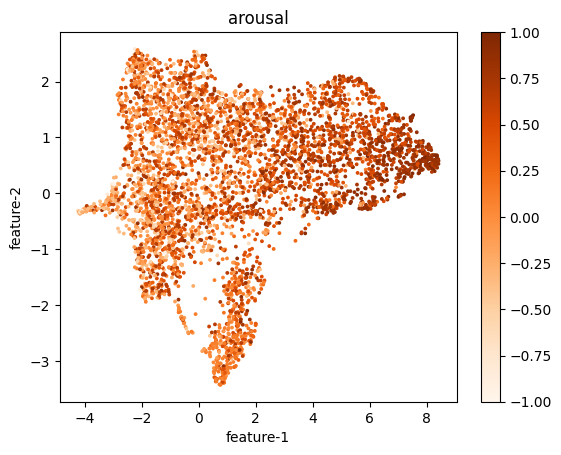

In [23]:
tokens, targets = CLE_tokens(model,
                             feature_extractor,
                             val_dataset,
                             device)
fig = plot_tokens(tokens, targets.squeeze(), 30)

In [24]:
wandb.log({'finetuned-plot': wandb.Image(fig)})

In [25]:
from transformers import ViTForImageClassification

non_finetuned_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                                num_labels=1,
                                                                problem_type='regression')


loading configuration file config.json from cache at C:\Users\rkn/.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k\snapshots\7cbdb7ee3a6bcdf99dae654893f66519c480a0f8\config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "regression",
  "qkv_bias": true,
  "transformers_version": "4.26.1"
}

loading weights file pytorch_model.bin from cache at C:\Users\rkn/.cache\huggingface\hub\models--google--vit-base-patch16-224-in21k\snapshots\7cbdb7ee

100%|██████████| 4500/4500 [01:57<00:00, 38.27it/s]


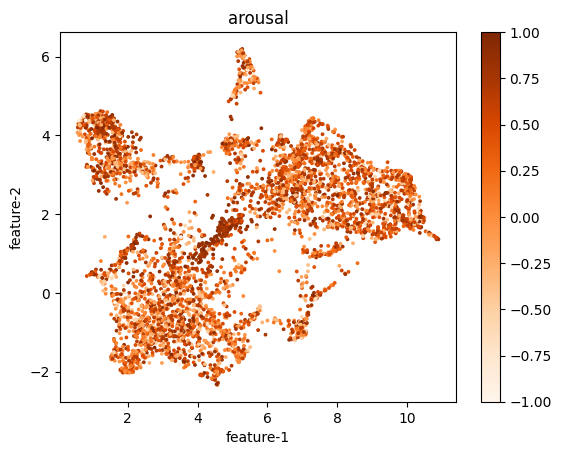

In [26]:
tokens, targets = CLE_tokens(non_finetuned_model.to(device),
                             feature_extractor,
                             val_dataset,
                             device)
fig = plot_tokens(tokens, targets.squeeze(), 30)
wandb.log({'non-finetuned-plot': wandb.Image(fig)})